In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from pdb import set_trace
import glob

In [2]:
ls

Blueprint Stats/                 headlessDLtest.py
Create All Times DF.ipynb        leaguelocationmap.py
Individual Player Stats.ipynb    leaguelocationmap_upload.xls
Pandas Demo.ipynb                pandas tutorial 1.py
Possession + Passes Stats.ipynb  parksusagereport.py
Possession Stats.ipynb           pull_admin_reports.py
amazonpricescraper.py            pullallshirtreports.py
blueprint-stats/                 pulldashboardreport.py
create activity type colum.py    seleniumtest.py
developer_survey_2019/           test_activity_type.xls
geckodriver.log                  zogadminlogin.py


In [3]:
cd 'blueprint-stats/library'

/Users/maxcohen/Documents/blueprint-stats/library


### ADD PLAYER STATS DF

In [4]:
player_stats_file = 'Blueprint 2019 Players.csv'
player_stats_df = pd.read_csv(player_stats_file)
player_stats_df

,Player,Points played total,Offense points played,Defense points played,Offense points won,Defense points won,Touches,Points played with touches,Throws,Catches,...,Stall outs for,Stall outs against,Total completed throw distance (m),Total completed throw gain (m),Average completed throw distance (m),Average completed throw gain (m),Total caught pass distance (m),Total caught pass gain (m),Average caught pass distance (m),Average caught pass gain (m)
0,Sam Alston,47,7,40,4,13,22,17,15,20,...,0,0,132.50,33.05,10.19,2.54,399.95,324.93,20.00,16.25
1,Eliot Bemis,52,45,7,32,3,54,35,45,53,...,0,0,615.97,392.37,14.32,9.12,851.24,681.43,16.06,12.86
2,Josh Imhoff,39,4,35,3,13,25,16,19,24,...,0,0,200.30,46.75,11.13,2.60,436.23,327.54,18.18,13.65
3,Victor Kao,55,52,3,33,2,98,46,96,79,...,0,0,"1,103.12",631.78,12.98,7.43,934.02,283.40,11.82,3.59
4,Ben West,8,0,8,0,2,1,1,1,1,...,0,0,12.35,2.26,12.35,2.26,19.60,19.28,19.60,19.28
5,Alon Brown,36,2,34,2,14,39,18,38,25,...,0,0,519.84,245.62,15.29,7.22,270.79,37.92,10.83,1.52
6,Jeff Voss,63,59,4,44,1,62,42,54,62,...,0,0,619.62,312.71,13.77,6.95,"1,062.67",759.53,17.14,12.25
7,Ian McInerney,42,23,19,17,7,33,21,28,33,...,0,0,293.24,149.15,11.73,5.97,495.10,373.45,15.00,11.32
8,Zero,33,3,30,3,15,10,8,9,9,...,0,0,100.23,26.62,11.14,2.96,127.80,84.82,14.20,9.42
9,Sam Pollack,64,63,1,41,0,54,41,49,54,...,0,0,635.76,263.91,13.24,5.50,835.63,640.18,15.47,11.86


In [5]:
#change all columns to numeric
column_list = ['Total completed throw distance (m)','Total completed throw gain (m)',
                 'Total caught pass distance (m)']
for i in column_list:
    player_stats_df[i] = [x.replace(',','') for x in player_stats_df[i]]
    player_stats_df[i] = pd.to_numeric(player_stats_df[i])             

In [6]:
#change index to payer name
player_stats_df = player_stats_df.set_index('Player')

In [35]:
#create player inits column
players = list(player_stats_df.index)
player_inits = []
for p in players:
    try:
        player_init = p.split(' ')[0][0] + p.split(' ')[1][0]
    except IndexError:
        player_init = p.split(' ')[0][:2]
    player_inits.append(player_init)

In [37]:
player_stats_df['player_inits'] = player_inits

In [7]:
player_stats_df.dtypes

Points played total                       int64
Offense points played                     int64
Defense points played                     int64
Offense points won                        int64
Defense points won                        int64
Touches                                   int64
Points played with touches                int64
Throws                                    int64
Catches                                   int64
Possessions initiated                     int64
Assists                                   int64
Secondary assists                         int64
Goals                                     int64
Turnovers                                 int64
Thrower errors                            int64
Receiver errors                           int64
Defensive blocks                          int64
Stall outs for                            int64
Stall outs against                        int64
Total completed throw distance (m)      float64
Total completed throw gain (m)          

In [8]:
#create a column for handler/cutter

In [9]:
#create a a new position_df to host player names and positions. will merge with player_df later
position_df = pd.DataFrame(columns=['Player','Position'])

In [10]:
position_df['Player'] = list(player_stats_df.index)

In [11]:
#manually enter all positions for players
position_df['Position'] = ['C','C','C','H','C','H','C','C','C','C','H','C','C','H','C','C','H','C','H','H','C','C',
                          'H','C','C','H','C','H']

In [12]:
#create a column for pecent of total points played that are offensive points
player_stats_df['percent_Opp'] = player_stats_df['Offense points played'] / player_stats_df['Points played total']

In [13]:
#assign players as 'offense', 'defense', or 'flex'
#assignment is split into thirds of playing time
#ex: < .33 of total points played on offense = 'defense'
#'flex' is the middle third
player_stats_df['Line'] = ['Off' if x >= .66 else 'def' if x < .33 else 'Flex' 
                           for x in player_stats_df['percent_Opp']]

In [14]:
#set player to index of position_df
position_df = position_df.set_index('Player')

In [15]:
#join position and player stats on the index of player
player_stats_df = player_stats_df.join(position_df)

### PLUS MINUS TABLE 

In [16]:
#create plus/minus column
#plus/minus = goals+assists+(.5*secondary assists)+blocks-turnovers
player_stats_df['plus/minus'] = player_stats_df['Goals'] + player_stats_df['Assists'] + \
player_stats_df['Secondary assists']*.5 + player_stats_df['Defensive blocks'] - player_stats_df['Turnovers']

In [17]:
#create offense plus/minus column
#same as plus minus except no blocks
player_stats_df['offense_plus/minus'] = player_stats_df['Goals'] + player_stats_df['Assists'] + \
player_stats_df['Secondary assists']*.5 - player_stats_df['Turnovers']

In [18]:
#show sorted plus/minus table
plus_minus = player_stats_df[['Position','Line','Touches','plus/minus','Goals','Assists',
                 'Secondary assists','Defensive blocks','Turnovers']].sort_values(by='plus/minus',ascending=False)
plus_minus

,Position,Line,Touches,plus/minus,Goals,Assists,Secondary assists,Defensive blocks,Turnovers
Player,,,,,,,,,
Ruozhou Ye,H,def,83,21.5,6,12,5,7,6
Eliot Bemis,C,Off,54,16.5,9,7,7,1,4
Owen Marschall,H,Off,98,12.0,7,3,0,5,3
Odie,C,Off,82,12.0,10,12,4,4,16
Sam Alston,C,def,22,11.0,7,2,0,4,2
Josh Imhoff,C,def,25,11.0,6,2,2,3,1
Geo Zheng,H,Flex,54,10.5,4,3,3,7,5
Carter Thallon,C,Off,53,9.5,3,8,5,0,4
Sam Pollack,C,Off,54,9.5,5,4,5,1,3


In [19]:
#show sorted offense plus/minus table
offense_plus_minus = player_stats_df[['Position','Line','offense_plus/minus','Goals','Assists','Secondary assists',
                                      'Turnovers']].sort_values(by='offense_plus/minus',ascending=False)
offense_plus_minus

,Position,Line,offense_plus/minus,Goals,Assists,Secondary assists,Turnovers
Player,,,,,,,
Eliot Bemis,C,Off,15.5,9,7,7,4
Ruozhou Ye,H,def,14.5,6,12,5,6
Carter Thallon,C,Off,9.5,3,8,5,4
Sam Pollack,C,Off,8.5,5,4,5,3
Josh Imhoff,C,def,8.0,6,2,2,1
Odie,C,Off,8.0,10,12,4,16
Sam Alston,C,def,7.0,7,2,0,2
Max Cohen,H,Off,7.0,2,11,12,12
Owen Marschall,H,Off,7.0,7,3,0,3


In [20]:
player_stats_df['Turnovers'].sum()

122

In [21]:
player_stats_df['Total completed throw distance (m)'].sum() / player_stats_df['Turnovers'].sum()

118.75573770491803

### TOTAL DISTANCE TABLE

In [22]:
#these stats are based on total distance
#total distance is absolute value of distance in both x and y directions

In [23]:
#create (distance thrown/thrower error)
player_stats_df['dist_throw/throw_error'] = player_stats_df['Total completed throw distance (m)'] / \
player_stats_df['Thrower errors']

#create (distance received/receiver error)
player_stats_df['dist_rec/rec_error'] = player_stats_df['Total caught pass distance (m)'] / \
player_stats_df['Receiver errors']

In [24]:
#create total distance (thrown distance + rec distance)
player_stats_df['total_dist'] = player_stats_df['Total completed throw distance (m)'] + \
player_stats_df['Total caught pass distance (m)']

#create (total dist/turnovers)
player_stats_df['total_dist/turn'] = player_stats_df['total_dist'] / player_stats_df['Turnovers']

In [25]:
#show sorted total distance/turn table
player_stats_df[['total_dist','total_dist/turn','dist_throw/throw_error',
                 'dist_rec/rec_error']].sort_values(by='total_dist/turn', ascending=False)

,total_dist,total_dist/turn,dist_throw/throw_error,dist_rec/rec_error
Player,,,,
Ben West,31.95,inf,inf,inf
Nadav Pearl,151.19,inf,inf,inf
Zero,228.03,inf,inf,inf
Josh Imhoff,636.53,636.530000,200.300000,inf
Owen Marschall,1770.21,590.070000,1073.900000,348.155
Sam Pollack,1471.39,490.463333,635.760000,417.815
Jon Kwan,443.73,443.730000,180.750000,inf
Eliot Bemis,1467.21,366.802500,307.985000,425.620
Carter Thallon,1352.55,338.137500,200.036667,752.440


In [26]:
player_stats_df.dtypes

Points played total                       int64
Offense points played                     int64
Defense points played                     int64
Offense points won                        int64
Defense points won                        int64
Touches                                   int64
Points played with touches                int64
Throws                                    int64
Catches                                   int64
Possessions initiated                     int64
Assists                                   int64
Secondary assists                         int64
Goals                                     int64
Turnovers                                 int64
Thrower errors                            int64
Receiver errors                           int64
Defensive blocks                          int64
Stall outs for                            int64
Stall outs against                        int64
Total completed throw distance (m)      float64
Total completed throw gain (m)          

### TOTAL GAIN TABLE 

In [27]:
#these stats are based on gain
#total gain is based on distance in the y direction towards the scoring endzone
#many of them are the same as total distance stats except just using gain instead of distance

In [28]:
player_stats_df['gain_throw/throw_error'] = player_stats_df['Total completed throw gain (m)'] / \
player_stats_df['Thrower errors']

player_stats_df['gain_rec/rec_error'] = player_stats_df['Total caught pass gain (m)'] / \
player_stats_df['Receiver errors']

In [29]:
player_stats_df['total_gain'] = player_stats_df['Total completed throw gain (m)'] + \
player_stats_df['Total caught pass gain (m)']

player_stats_df['total_gain/turn'] = player_stats_df['total_gain'] / player_stats_df['Turnovers']

In [63]:
player_stats_df[['total_gain','Total completed throw gain (m)','Total caught pass gain (m)',
                 'total_gain/turn','gain_throw/throw_error',
                 'gain_rec/rec_error']].sort_values(by='total_gain/turn', ascending=False)

,total_gain,Total completed throw gain (m),Total caught pass gain (m),total_gain/turn,gain_throw/throw_error,gain_rec/rec_error
Player,,,,,,
Ben West,21.54,2.26,19.28,inf,inf,inf
Nadav Pearl,66.24,48.80,17.44,inf,inf,inf
Zero,111.44,26.62,84.82,inf,inf,inf
Josh Imhoff,374.29,46.75,327.54,374.290000,46.750000,inf
Sam Pollack,904.09,263.91,640.18,301.363333,263.910000,320.090000
Jon Kwan,296.75,122.46,174.29,296.750000,122.460000,inf
Eliot Bemis,1073.80,392.37,681.43,268.450000,196.185000,340.715000
Owen Marschall,713.49,583.55,129.94,237.830000,583.550000,64.970000
Carter Wang,412.21,88.98,323.23,206.105000,44.490000,inf


In [100]:
#adjust total_gain/turn by usage rate
(player_stats_df['thrower_usage'] * player_stats_df['total_gain/turn']).sort_values(ascending=False)

Player
Zero                       inf
Ben West                   inf
Nadav Pearl                inf
Max Cohen          2314.015477
Owen Marschall     1860.922614
Sam Pollack        1269.716538
Ruozhou Ye         1062.871453
Eliot Bemis        1038.714531
Andrew Edelman      838.088277
Victor Kao          755.436629
Carter Thallon      718.970335
Jeff Voss           622.323302
Josh Imhoff         611.479794
Odie                495.085125
Evan Ma             462.343078
Carter Wang         389.880482
Jon Kwan            331.706793
Geo Zheng           328.933792
Ian McInerney       314.548581
Sam Alston          230.855546
Gabe Stump          225.528805
Towell              179.681857
Alon Brown          154.406993
Juleon Robinson     140.060189
Sam Feder           102.317283
Jesse Gan            75.459731
Stouf                56.715391
Swan                 43.473130
dtype: float64

In [65]:
player_stats_df['total_gain/turn'].median()

132.34

In [66]:
total_gain_turn_df = player_stats_df[['player_inits','total_gain/turn',
                                      'total_gain']].sort_values(by='total_gain/turn',ascending=False)

In [67]:
total_gain_turn_df = total_gain_turn_df.replace(np.inf,np.nan).dropna()


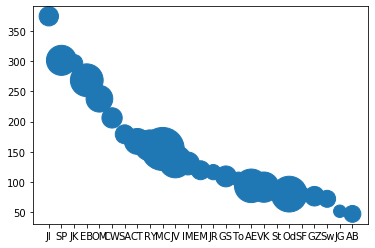

In [68]:
plt.scatter(total_gain_turn_df['player_inits'],total_gain_turn_df['total_gain/turn'],
       s=total_gain_turn_df['total_gain'])

### SCORE RATE TABLE

In [69]:
#these stats are simple calculations of how often the team scored when the player was on the field
#stats for o,d,total

In [70]:
player_stats_df.columns

Index(['Points played total', 'Offense points played', 'Defense points played',
       'Offense points won', 'Defense points won', 'Touches',
       'Points played with touches', 'Throws', 'Catches',
       'Possessions initiated', 'Assists', 'Secondary assists', 'Goals',
       'Turnovers', 'Thrower errors', 'Receiver errors', 'Defensive blocks',
       'Stall outs for', 'Stall outs against',
       'Total completed throw distance (m)', 'Total completed throw gain (m)',
       'Average completed throw distance (m)',
       'Average completed throw gain (m)', 'Total caught pass distance (m)',
       'Total caught pass gain (m)', 'Average caught pass distance (m)',
       'Average caught pass gain (m)', 'percent_Opp', 'Line', 'Position',
       'plus/minus', 'offense_plus/minus', 'dist_throw/throw_error',
       'dist_rec/rec_error', 'total_dist', 'total_dist/turn',
       'gain_throw/throw_error', 'gain_rec/rec_error', 'total_gain',
       'total_gain/turn', 'player_inits'],
      dtyp

In [71]:
player_stats_df['O_score_rate'] = player_stats_df['Offense points won'] / \
player_stats_df['Offense points played']

player_stats_df['d_score_rate'] = player_stats_df['Defense points won'] / \
player_stats_df['Defense points played']

player_stats_df['total_score_rate'] = (player_stats_df['Defense points won']+player_stats_df['Offense points won'])/ \
player_stats_df['Points played total']

In [72]:
score_rate_table = player_stats_df[['Position','Line','total_score_rate','O_score_rate','d_score_rate',
                 ]].sort_values(by='total_score_rate', ascending=False)
score_rate_table

,Position,Line,total_score_rate,O_score_rate,d_score_rate
Player,,,,,
Owen Marschall,H,Off,0.796610,0.796610,NaN
Carter Thallon,C,Off,0.725000,0.725000,NaN
Max Cohen,H,Off,0.714286,0.714286,NaN
Jeff Voss,C,Off,0.714286,0.745763,0.250000
Odie,C,Off,0.704918,0.795918,0.333333
Gabe Stump,C,Off,0.684211,0.684211,NaN
Eliot Bemis,C,Off,0.673077,0.711111,0.428571
Nadav Pearl,H,def,0.666667,NaN,0.666667
Sam Pollack,C,Off,0.640625,0.650794,0.000000


### FIGURE OUT ZSCORE

In [73]:
#testing zscore as a method for determining relative score rate across players on the team

In [74]:
zscore_rate_table = score_rate_table.copy()

In [75]:
numeric_cols = zscore_rate_table.select_dtypes(include=[np.number]).columns

In [76]:
zscore_rate_table[numeric_cols].columns

Index(['total_score_rate', 'O_score_rate', 'd_score_rate'], dtype='object')

In [77]:
#find the zscore of every value
for i in zscore_rate_table[numeric_cols].columns:
    zscore_rate_table[i] = (zscore_rate_table[i] - zscore_rate_table[i].mean()) / zscore_rate_table[i].std(ddof=0)

In [78]:
zscore_rate_table.columns = [x.replace('rate','z') for x in zscore_rate_table.columns]
zscore_rate_table

,Position,Line,total_score_z,O_score_z,d_score_z
Player,,,,,
Owen Marschall,H,Off,1.846670,0.356527,NaN
Carter Thallon,C,Off,1.348271,-0.162366,NaN
Max Cohen,H,Off,1.273701,-0.240002,NaN
Jeff Voss,C,Off,1.273701,-0.011917,-1.067092
Odie,C,Off,1.208503,0.351514,-0.428082
Gabe Stump,C,Off,1.064381,-0.457929,NaN
Eliot Bemis,C,Off,0.986892,-0.263006,0.302215
Nadav Pearl,H,def,0.942278,NaN,2.127959
Sam Pollack,C,Off,0.761030,-0.700070,-2.984123


### OVERALL BOX SCORE

In [79]:
#my attempt at showcasing a table of the "most important" individual player stats

In [80]:
#total stats and per-point-played stats
#from left to right
#name,position
#points played (o/d)
#touches, +/-, goals, assists, hockey assists, d's, turns
#yardage gained (throw/rec)
#score rate
#team totals at the bottom

In [81]:
#create completion percentage
player_stats_df['throw_completion_rate'] = (1 - (player_stats_df['Thrower errors'] / player_stats_df['Throws'])) * 100
player_stats_df['throw_completion_rate'] = player_stats_df['throw_completion_rate'].round(decimals=2)

In [82]:
box_score = player_stats_df[['Position','Line','Points played total',
                 'Touches','plus/minus','Goals','Assists','Secondary assists','Defensive blocks','Turnovers',
                 'throw_completion_rate','total_gain','Total completed throw gain (m)','Total caught pass gain (m)',
                 'O_score_rate','d_score_rate']].sort_values(by=['plus/minus','total_gain'],ascending=False)
box_score

,Position,Line,Points played total,Touches,plus/minus,Goals,Assists,Secondary assists,Defensive blocks,Turnovers,throw_completion_rate,total_gain,Total completed throw gain (m),Total caught pass gain (m),O_score_rate,d_score_rate
Player,,,,,,,,,,,,,,,,
Ruozhou Ye,H,def,78,83,21.5,6,12,5,7,6,96.10,963.21,732.77,230.44,0.888889,0.463768
Eliot Bemis,C,Off,52,54,16.5,9,7,7,1,4,95.56,1073.80,392.37,681.43,0.711111,0.428571
Odie,C,Off,61,82,12.0,10,12,4,4,16,83.33,1279.52,490.11,789.41,0.795918,0.333333
Owen Marschall,H,Off,59,98,12.0,7,3,0,5,3,98.90,713.49,583.55,129.94,0.796610,NaN
Josh Imhoff,C,def,39,25,11.0,6,2,2,3,1,94.74,374.29,46.75,327.54,0.750000,0.371429
Sam Alston,C,def,47,22,11.0,7,2,0,4,2,86.67,357.98,33.05,324.93,0.571429,0.325000
Geo Zheng,H,Flex,78,54,10.5,4,3,3,7,5,94.00,382.55,210.59,171.96,0.750000,0.360000
Sam Pollack,C,Off,64,54,9.5,5,4,5,1,3,97.96,904.09,263.91,640.18,0.650794,0.000000
Carter Thallon,C,Off,40,53,9.5,3,8,5,0,4,94.00,668.93,241.74,427.19,0.725000,NaN


### HANDLER NUMBER (https://twitter.com/sotgstats/status/885529847623274496/photo/1)

In [83]:
#fun handler focused stat from another person's brain

In [84]:
player_stats_df['thrower_usage'] = player_stats_df['Throws'] / player_stats_df['Throws'].sum() * 100

In [85]:
player_stats_df['handler_number'] = player_stats_df['thrower_usage'] + player_stats_df['throw_completion_rate']

In [86]:
player_stats_df['thrower_usage'].sort_values(ascending=False)

Player
Max Cohen          14.961307
Andrew Edelman      8.942390
Victor Kao          8.254514
Owen Marschall      7.824592
Ruozhou Ye          6.620808
Odie                6.190886
Jeff Voss           4.643164
Carter Thallon      4.299226
Geo Zheng           4.299226
Sam Pollack         4.213242
Evan Ma             3.869304
Eliot Bemis         3.869304
Alon Brown          3.267412
Ian McInerney       2.407567
Gabe Stump          2.063629
Carter Wang         1.891660
Towell              1.719690
Josh Imhoff         1.633706
Jesse Gan           1.461737
Sam Alston          1.289768
Sam Feder           1.289768
Juleon Robinson     1.203783
Jon Kwan            1.117799
Zero                0.773861
Stouf               0.687876
Swan                0.601892
Nadav Pearl         0.515907
Ben West            0.085985
Name: thrower_usage, dtype: float64

In [87]:
player_stats_df['handler_number'].sort_values(ascending=False)

Player
Max Cohen          108.061307
Owen Marschall     106.724592
Ruozhou Ye         102.720808
Sam Pollack        102.173242
Zero               100.773861
Nadav Pearl        100.515907
Ben West           100.085985
Eliot Bemis         99.429304
Victor Kao          98.874514
Andrew Edelman      98.362390
Carter Thallon      98.299226
Geo Zheng           98.299226
Evan Ma             97.199304
Josh Imhoff         96.373706
Jon Kwan            93.427799
Carter Wang         92.801660
Alon Brown          92.737412
Towell              91.719690
Ian McInerney       91.697567
Jeff Voss           91.683164
Jesse Gan           89.701737
Odie                89.520886
Stouf               88.187876
Sam Alston          87.959768
Juleon Robinson     86.913783
Gabe Stump          85.393629
Sam Feder           81.289768
Swan                57.741892
Name: handler_number, dtype: float64

### TEAM STATS

In [88]:
player_stats_df.columns

Index(['Points played total', 'Offense points played', 'Defense points played',
       'Offense points won', 'Defense points won', 'Touches',
       'Points played with touches', 'Throws', 'Catches',
       'Possessions initiated', 'Assists', 'Secondary assists', 'Goals',
       'Turnovers', 'Thrower errors', 'Receiver errors', 'Defensive blocks',
       'Stall outs for', 'Stall outs against',
       'Total completed throw distance (m)', 'Total completed throw gain (m)',
       'Average completed throw distance (m)',
       'Average completed throw gain (m)', 'Total caught pass distance (m)',
       'Total caught pass gain (m)', 'Average caught pass distance (m)',
       'Average caught pass gain (m)', 'percent_Opp', 'Line', 'Position',
       'plus/minus', 'offense_plus/minus', 'dist_throw/throw_error',
       'dist_rec/rec_error', 'total_dist', 'total_dist/turn',
       'gain_throw/throw_error', 'gain_rec/rec_error', 'total_gain',
       'total_gain/turn', 'player_inits', 'O_score_ra

In [89]:
total_scoring_rate = ((player_stats_df['Offense points won'].sum() + player_stats_df['Defense points won'].sum()) /
                      player_stats_df['Points played total'].sum()) * 100

In [90]:
offense_scoring_rate = (player_stats_df['Offense points won'].sum() / 
                        player_stats_df['Offense points played'].sum() *
                        100)

In [91]:
defense_scoring_rate = (player_stats_df['Defense points won'].sum() / 
                        player_stats_df['Defense points played'].sum() *
                        100)

In [92]:
throw_completion_percentage = (1 - (player_stats_df['Thrower errors'].sum() / player_stats_df['Throws'].sum())) * 100

In [93]:
#Thrower errors + receiver errors == turnovers
#so the data has too many turnovers?
player_stats_df['Thrower errors'].sum() + player_stats_df['Receiver errors'].sum() == player_stats_df['Turnovers'].sum()

True

In [94]:
player_stats_df['Turnovers'].sum()

122

In [95]:
#TODO 
#there are 13 instances of turnovers that are assigned to both thrower and receiver
#those are being double counted and leading to 13 extra turnovers in this data set
#change each of those instances to be .5 turnovers